## Classification Description


### Importing libraries

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import (
    ensemble,
    preprocessing,
    tree,
    impute,
    metrics
)

from sklearn.metrics import (
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold
)

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC,
)

from sklearn.linear_model import (
    LogisticRegression
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (
    KNeighborsClassifier
)

from yellowbrick.model_selection import LearningCurve
from sklearn.experimental import enable_iterative_imputer
import pandas_profiling

from sklearn import model_selection
from sklearn.dummy import DummyClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier
)

import xgboost



In [20]:
df = pd.read_excel(r"D:\GitHub\Machine_Learning_MattHarrison\Classification_Description\titanic3.xls")

def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)

    return df

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare"
    ]
    fi = impute.IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])

    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:, std_cols] = std.transform(X_test[std_cols])
    
    return X_train, X_test, y_train, y_test


ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, "survived", std_cols=std_cols)

bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test)

metrics.precision_score(
    y_test, bm.predict(X_test)
)

d:\anaconda3\envs\ML_MattHarrison\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier
]:
    cls = model()
    kfold = model_selection.KFold(
        n_splits=10, random_state=42, shuffle=True
    )
    s = model_selection.cross_val_score(
        cls, X, y, scoring="roc_auc", cv=kfold
    )
    print(
        f"{model.__name__:22} AUC: {s.mean():.3f} STD: {s.std:.2f}"
    )

# This should be comparing different algoritms using the AUC score

### Model

In [26]:
# Creating a model (random forest)

rf = ensemble.RandomForestClassifier(
    n_estimators=100, random_state=42
)

rf.fit(X_train, y_train)

rf5 = ensemble.RandomForestClassifier(
    **{
        "max_features": "auto",
        "min_samples_leaf": 0.1,
        "n_estimators": 200,
        "random_state": 42,
    }
)

rf5.fit(X_train, y_train)

# Evaluating the model

print(rf.score(X_test, y_test))
print(metrics.precision_score(y_test, rf.predict(X_test)))

d:\anaconda3\envs\ML_MattHarrison\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.7837150127226463
0.7916666666666666


In [25]:
for col, val in sorted(
    zip(
        X_train.columns,
        rf.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10} {val:10.3f}")

age             0.285
fare            0.262
sex_male        0.241
pclass          0.089
sibsp           0.050


d:\anaconda3\envs\ML_MattHarrison\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


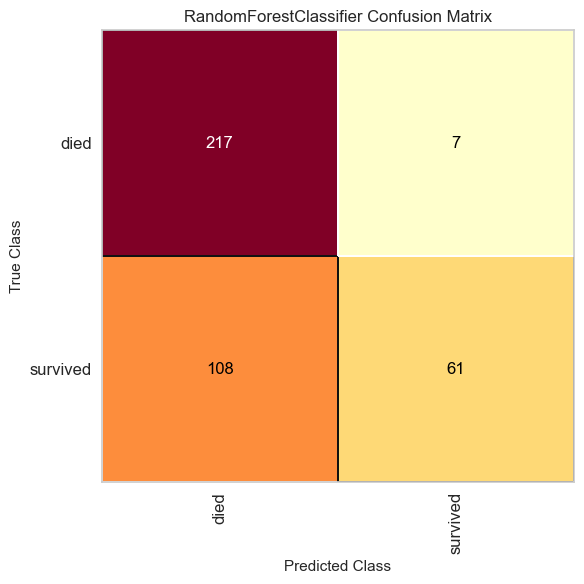

In [30]:
# Confusion Matrix

y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)

mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    rf5,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()
fig.savefig(
    "lpr_0304.png",
    dpi=300,
    bbox_inches="tight",
)